In [1]:
import sys
sys.path.append('../python') #Path to load WI_Solver_Utils.py
import WI_Solver_utils
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import trange
from WI_Solver_utils import InflatonModel, Background, Perturbations, Growth_factor
matplotlib.rcParams.update({'errorbar.capsize': 2})
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')

def format_fit_pars(pars, mode='complex'):
    global formatted_pars
    if mode=='complex':
        formatted_pars=[r'$b_1=',r'$b_2=',r'$b_3=',r'$b_4=',r'$b_5=',r'$b_6=',r'$a_1=,',r'$a_2=',r'$a_3=',r'$a_4=',r'$a_5=',r'$a_6=']
    if mode=='simple':
        formatted_pars=[r'$\alpha=',r'$\beta=',r'$A=',r'$B=']
    for i in range(len(pars)):
        pv=pars[i]
        exp = math.floor(math.log10(abs(pv))) # automatically detect the value of c
        if (exp>=1) or (exp<=-2):
            formatted_pv = "{:.2f}⋅10^{{{}}}".format(pv / 10**exp, exp)
        else:
            formatted_pv = "{:.2f}".format(pv)
        #Add formatted_pv to the ith element of formatted_pars, before the last $ sign:
        formatted_pars[i]=formatted_pars[i]+formatted_pv+'$'
    #Return as a single string of two columns with commas between the elements:
    return ', '.join(formatted_pars[:len(pars)//2])+'\n '+', '.join(formatted_pars[len(pars)//2:])

In [2]:
####################################################################
#   Define tau array over which we solved for the perturbations:   #
####################################################################
"""Recall: \tau=\ln(z)=\ln(k/(aH))"""

tau_ini = 6
tau_end = -1
N = 100000
dtau = (tau_end - tau_ini) / N # DT is a negative quantity as expected since tau is decreasing over time
taus = np.linspace(tau_ini, tau_end, N)


#################################
#   Define Global Parameters:   #
#################################

Mpl = 1 # Everything is in Plank units M_{pl}
g = 228.27  # SUSY relativistic degrees of freedom
a1 = np.pi**2/30*g

Neinflation=60 #Number of e-folds of inflation
Nruns=1024 #How many runs did we average over to compute the perturbations
MPs_bool='wo' #without metric perturbations
epsH_etaH_bool='wo' #negligible epsH and etaH

#cm_cases=[[0,0],[0,-1],[3,2],[3,0],[1,0],[-1,0],[-1,2]]

cm_cases=[[3,0],[1,0],[-1,0]]


In [3]:
#######################################################################
#   Define the type of inflaton potential and its main parammeters:   #
#######################################################################

potential_type='quartic'

lv = 10**(-14)  # value of lambda

Model = InflatonModel('monomial', [lv, 4], g, a1, Mpl)


################################################
#   Initial conditions on \phi0 and Q array:   #
################################################

"""
Note here we load previously computed initial conditions that guarantee N_e= Neinflation + 8 efolds of inflation.
To see how these were computed, check out the notebook "ICs_ph0.ipynb"
"""

ICs_Q0_ph0=np.loadtxt('../ICS_ph0-Q0s/ICS_ph0-Q0s_'+potential_type+'_Ne'+str(int(Neinflation))+'.txt')
Q0s=ICs_Q0_ph0[:,0]
ph0s=ICs_Q0_ph0[:,1]

########################################################################
#   Compute the Analytic approximation of the Power spectrum for c=0   #
########################################################################

R2_analytic=np.zeros(len(Q0s))
for i in trange(len(Q0s)):
    Bg=Background(Model,ph0s[i],Q0s[i])
    R2_analytic[i]=Bg.analytic_power_spectrum(int(Neinflation+11), 10**(6), taus, Neinflation)
    del Bg


100%|███████████████████████████████████████████| 52/52 [00:34<00:00,  1.49it/s]


In [4]:
R2m_list, R2std_list=[],[]
for i in trange(len(cm_cases)):
    cval=cm_cases[i][0]
    mval=cm_cases[i][1]
    _,R2m,R2std=np.loadtxt('../WI_PowerSpectra_data/PowerSpectra_'+str(MPs_bool)+'MPs_'+str(epsH_etaH_bool)+'epsH-etaH_'+potential_type+'_c'+str(cval)+'m'+str(mval)+'_n'+str(int(N))+'_Nr'+str(int(Nruns))+'_Ne'+str(int(Neinflation))+'.txt')
    R2m_list.append(R2m)
    R2std_list.append(R2std)
    del R2m, R2std
R2m_list=np.array(R2m_list)
R2std_list=np.array(R2std_list)

100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 2180.75it/s]


[14.99998978  2.25074159  4.76113742 14.9985125   1.26791256]
[ 3.77363104 11.4082319  12.06541366  1.81032611 11.49958587]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.63116144 0.80538078 0.25678436 4.15589401 0.18669266 5.        ]


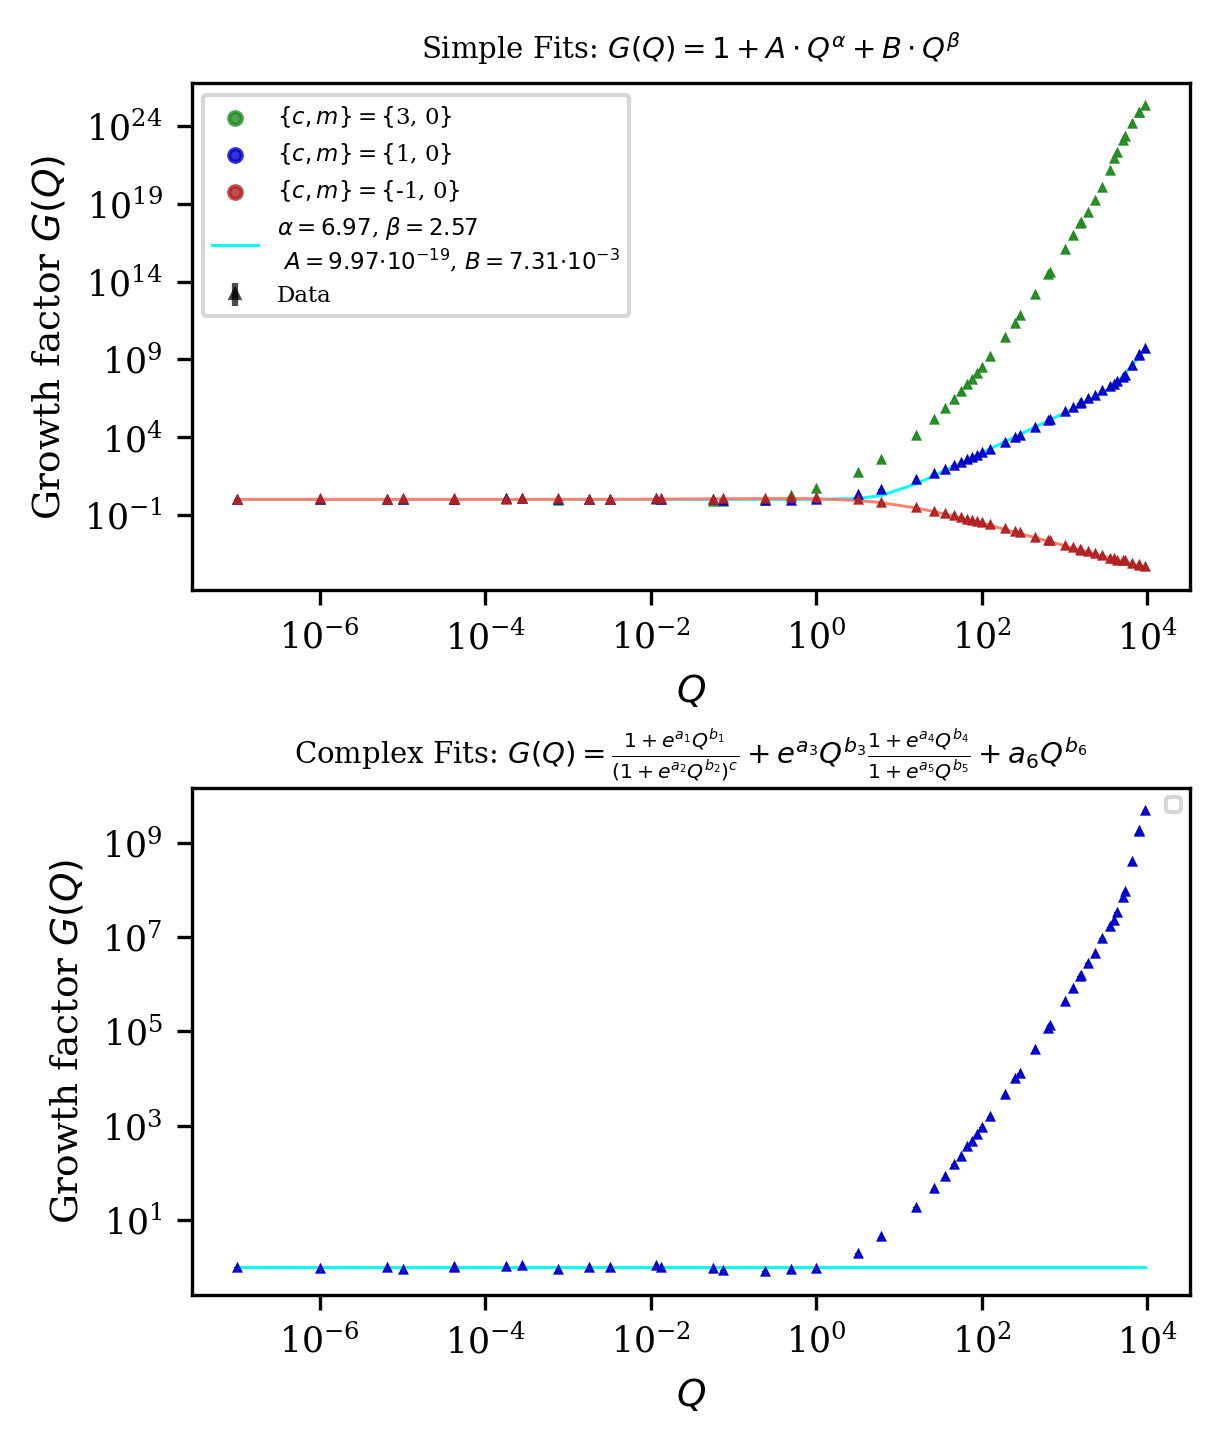

In [6]:
#Make Figure where I plot the data and the fit:
fig1=plt.figure(figsize=(4.5,5.8),dpi=300)
gs1 = GridSpec(42,44,figure=fig1)
ax1 = fig1.add_subplot(gs1[2:18,1:-1])
ax2 = fig1.add_subplot(gs1[24:40,1:-1])

ax1.set_xlabel("$Q$",fontdict={'fontsize':9,'family':'serif'})
ax1.set_ylabel("Growth factor $G(Q)$",fontdict={'fontsize':9,'family':'serif'})
ax1.set_title(r"Simple Fits: $G(Q)=1+A \cdot Q^{\alpha}+B\cdot Q^{\beta}$",fontdict={'fontsize':7,'family':'serif'})
ax1.errorbar(np.NaN, np.NaN, yerr=np.NaN,c='k', label=r'Data', marker='^',ls='none',markersize=2,alpha=0.7)

cm_cols_data=['forestgreen','mediumblue','firebrick']
cm_cols_fits=['lime','cyan','salmon']

for i in range(len(cm_cases)):
    ax1.scatter(np.NaN, np.NaN,ls='None',marker='.',color=cm_cols_data[i],alpha=0.8, label='$\{c,m\}=\{$'+str(cm_cases[i][0])+', '+str(cm_cases[i][1])+'$\}$')
for i in range(len(cm_cases)):
    Gf=Growth_factor(Model,Q0s,ph0s,R2m_list[i],R2std_list[i],Nruns,int(Neinflation+11),10**(6),taus,Neinflation,cm_cases[i][0],cm_cases[i][1])
    pars_simple,_,GQ_sig,GQ_err=Gf.growth_factor_fit(method='simple',output_data=True,analytic_power_spectrum=True, deltaR2_analytic=R2_analytic)
    pars_complex,_=Gf.growth_factor_fit(method='complex_v2',output_data=False,analytic_power_spectrum=True, deltaR2_analytic=R2_analytic)
    print(pars_complex)
    ax1.errorbar(Q0s,GQ_sig,yerr=GQ_err,c=cm_cols_data[i],marker='^',ls='none',markersize=1)    
    if cm_cases[i][0]==1:
        ax2.errorbar(Q0s,GQ_sig,yerr=GQ_err,c=cm_cols_data[i],marker='^',ls='none',markersize=1)    
        ax1.plot(Q0s,Gf.growth_factor_fit_func_positive_c_simple(Q0s,*pars_simple),c=cm_cols_fits[i],label=format_fit_pars(pars_simple,'simple'),linewidth=0.7)
        ax2.plot(Q0s,Gf.growth_factor_fit_func_positive_c_complex_v2(Q0s,*pars_complex),c=cm_cols_fits[i],linewidth=0.7)
    if cm_cases[i][0]==-1:
        ax1.plot(Q0s,Gf.growth_factor_fit_func_negative_c(Q0s,*pars_simple),c=cm_cols_fits[i],linewidth=0.7)        
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend(prop={'family':'serif','size':5.5},framealpha=0.8)

ax2.set_xlabel("$Q$",fontdict={'fontsize':9,'family':'serif'})
ax2.set_ylabel("Growth factor $G(Q)$",fontdict={'fontsize':9,'family':'serif'})
ax2.set_title(r"Complex Fits: $G(Q)=\frac{1+e^{a_1}Q^{b_1}}{(1+e^{a_2}Q^{b_2})^{c}}+e^{a_3}Q^{b_3}\frac{1+e^{a_4}Q^{b_4}}{1+e^{a_5}Q^{b_5}}+a_6 Q^{b_6}$",fontdict={'fontsize':7,'family':'serif'})
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.legend(prop={'family':'serif','size':4.5},framealpha=0.8)


plt.show()
plt.close()
